<a href="https://colab.research.google.com/github/javmencia/STA365javierMencia/blob/main/RegressionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
from scipy import stats
import time
import math

def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

In [32]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood
    mu = pm.Deterministic("mu", pm.math.dot(X, beta))
    y_ = pm.MvNormal('y_', mu=mu, cov= (sigma0**2)*np.eye(n), shape = n)

    # Prior log-probability
    prior_pd = pm.Deterministic("prior_pd", pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2)*np.eye(n), shape=(n,)), mu).sum())

    # Posterior mean and covariance for beta
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    print(cov_beta_post)
    mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, y)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))
    print(mean_beta_post)

    # Posterior log-probability
    posterior_beta = pm.MvNormal('posterior_beta', mu=mean_beta_post, cov=cov_beta_post)
    posterior_pd = pm.Deterministic("posterior_pd", pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_beta), cov=(sigma0**2)*np.eye(n), shape=(n, )), mu).sum())

    # Log BR
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_pd - prior_pd)

    # Likelihood
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2)*np.eye(n), shape=n), y_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

y [ 2.02285181  3.72778458 -0.090022    0.80840662 -0.8493315   4.81056796
 -3.30669514 -0.59163993 -2.15400519 -1.01798558 -1.9658222  -3.54945497
  2.09785444  1.25024263 -1.13535921 -0.4309976   0.52444264  4.91380017
  2.14464964 -1.80711183]
[[ 0.06352878 -0.02965681]
 [-0.02965681  0.07935113]]
[1.09114098 1.74170568]


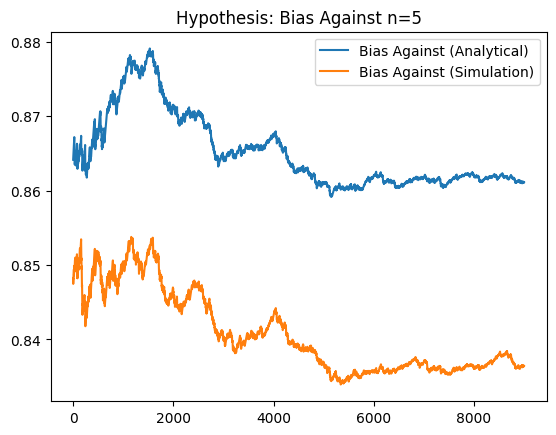

In [27]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

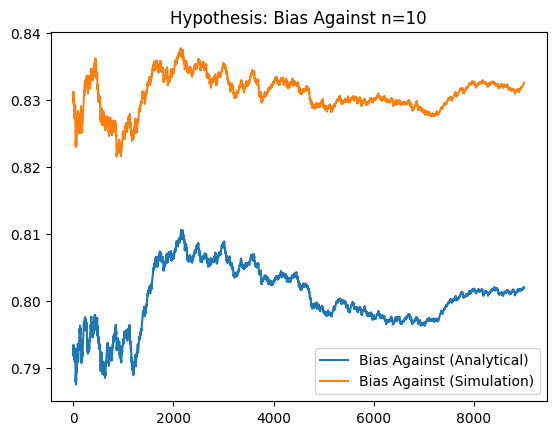

In [29]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

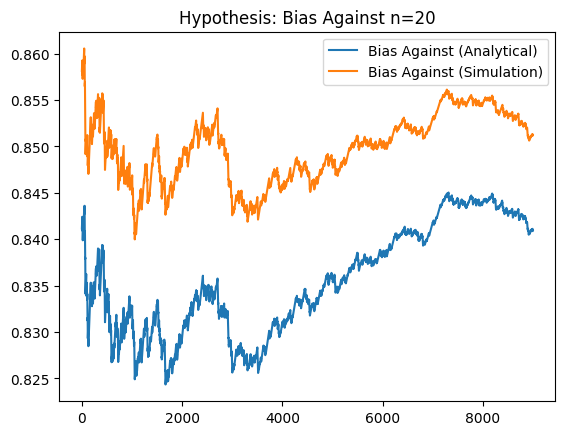

In [33]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

Bias In Favor

In [35]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
delta = 0.05
sigma0 = 1
betal = beta0 - delta
betau = beta0 + delta
mu0 = np.dot(X, beta0)
mul = np.dot(X, betal)
muu = np.dot(X, betau)

# Generate response variable y
yl = mul + np.random.normal(0, sigma0, n)
yu = muu + np.random.normal(0, sigma0, n)


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood
    mu = pm.Deterministic("mu", pm.math.dot(X, beta))
    y_l = pm.MvNormal('y_l', mu=mul, cov= (sigma0**2)*np.eye(n), shape = n)
    y_u = pm.MvNormal('y_u', mu=muu, cov= (sigma0**2)*np.eye(n), shape = n)

    # Prior log-probability
    prior_pd = pm.Deterministic("prior_pd", pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2)*np.eye(n), shape=(n,)), mu).sum())

    # Posterior mean and covariance for beta
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    print(cov_beta_post)
    mean_beta_postl = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))
    mean_beta_postu = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yu)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))

    # Posterior log-probability
    posterior_betal = pm.MvNormal('posterior_betal', mu=mean_beta_postl, cov=cov_beta_post)
    posterior_betau = pm.MvNormal('posterior_betau', mu=mean_beta_postu, cov=cov_beta_post)

    posterior_pdl = pm.Deterministic("posterior_pdl", pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betal), cov=(sigma0**2)*np.eye(n), shape=(n, )), mu).sum())
    posterior_pdu = pm.Deterministic("posterior_pdu", pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betau), cov=(sigma0**2)*np.eye(n), shape=(n, )), mu).sum())

    # Log BR
    logBR_prior_pdl = pm.Deterministic("logBR_prior_pdl", posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic("logBR_prior_pdu", posterior_pdu - prior_pd)

    # Likelihood
    likelihood_prior_pdl = pm.Deterministic("likelihood_prior_pdl", pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2)*np.eye(n), shape=n), y_l).sum())
    likelihood_prior_pdu = pm.Deterministic("likelihood_prior_pdu", pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2)*np.eye(n), shape=n), y_u).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

[[ 6.0978131e-02 -3.9950332e-05]
 [-3.9950332e-05  6.3202296e-02]]


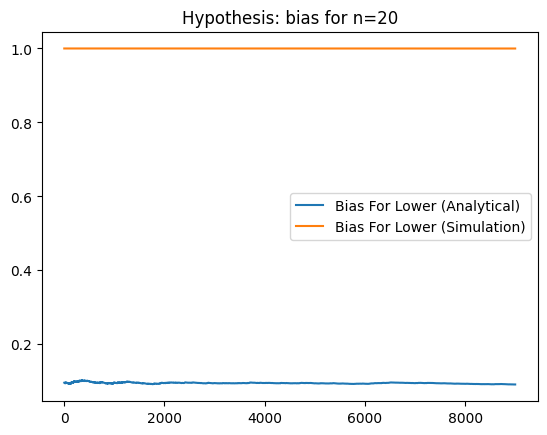

In [37]:
bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
xl_samples = idata.posterior['y_l'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['y_u'].values  # Shape (chains, draws, n)


# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu '].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()
